# Register of renewable energy power plants in Germany

This Jupyter Notebook is part of the "Open Power System Data" Project. The aim is to extract, merge, clean and verify different sources with data of renewable energy (RE) power plants in Germany. The data is downloaded from three diffrent sources:
* [BNetzA](http://www.bundesnetzagentur.de/) - The German Federal Network Agency for Electricity, Gas, Telecommunications, Posts and Railway 
* [EnergyMap.info](http://www.energymap.info/) - The German Society for Solarpower e.V. 
* [Netztransparenz.de](https://www.netztransparenz.de/de/Anlagenstammdaten.htm) - Information platform from the german TSOs

In Germany all data is mandatorily reported by the four TSOs (50 Herz, Amprion, Tennet, TransnetBW). The BNetzA merges them and EnergyMap.info additionally validates and converts the data into a standard format. The EnergyMap.info register includes all RE power plants which are eligible for the German feed-in tariff (according to the EEG law). EnergyMap.info is the main source for all historical data (installed until July 2014)

Note: Since 2014 the BNetzA itself is responsible to publish the renewable power plants register. The legal framework for the register is  specified in the [EEG 2014 (German)](http://www.gesetze-im-internet.de/eeg_2014/) [(English)](http://www.res-legal.eu/search-by-country/germany/single/s/res-e/t/promotion/aid/feed-in-tariff-eeg-feed-in-tariff/lastp/135/). From June 2014 on all power plants are published in two separated MS Excel files (roof mounted PV systems and all other renewable power plants). Additionaly the Data from [Netztransparenz.de](https://www.netztransparenz.de/de/Anlagenstammdaten.htm) is included in the script to eliminate missing values and timelines.


# License

* This notebook is published under the GNU GPL v3 license. http://www.gnu.org/licenses/gpl-3.0.en.html.
* This notebook is developed by the project Open Power System Date (OPSD.) http://open-power-system-data.org/

# Table of contents 


(work in progress)
* [Register of renewable energy power plants in Germany](#Register-of-renewable-energy-power-plants-in-Germany)
* [License](#Licence)
* [Import python modules](#Import-python-modules)
* [Data overview](#Data-overview)
* [Download and extract data](#Download-an-extracting-data-from-data-sources)
    * [Unzip and load data as Data Frame](#Unzip-and-load-data-as-data-frame)
    * [Definition of column names](#Definition-of-column-names)
    * [First look at the Data Frame structure and format](#First-look-at-the-Data-Frame-structure-and-format)
    * [Rename values by own english standards](#Rename-values-by-own-english-standards)

* [Find duplicantes and other suspect data](#Find-duplicantes-and-other-suspect-data)

* [Georeferencing get coordinates](#Georeferencing-get-coordinates)
* [Geoploting test](#Geoplot-testing)
* [Documenting the data package in a JSON object](#Documenting-the-data-package-in-a-JSON-object)
* [Write Data Package to disk](#Write-Data-Package-to-disk)


# Import Python modules

In [1]:
%matplotlib inline

from collections import OrderedDict
import io
import json
import os
import subprocess
import zipfile
import posixpath
import urllib.parse
import urllib.request
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import requests
import yaml  # http://pyyaml.org/, pip install pyyaml, conda install pyyaml
import datetime  

import logging
logger = logging.getLogger('notebook')
logger.setLevel('INFO')
nb_root_logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s'\
                              '- %(message)s',datefmt='%d %b %Y %H:%M:%S')
nb_root_logger.handlers[0].setFormatter(formatter)



#create download and output folders if they don't exist
if not os.path.exists('input/'): os.makedirs('input/')
if not os.path.exists('output/'): os.makedirs('output/')
if not os.path.exists('output/datapackage_renewables'): os.makedirs('output/ \
                                                      datapackage_renewables')


# Data overview

The data processed in this notebook is provided by and downloaded from three different sources. This is done due to the fact, that all sources have different timeperiods, missing data and are inaccurate or imcomplete.

####  Bundesnetzagentur (BNetzA)

The German Federal Network Agency for Electricity, Gas, Telecommunications, Posts and Railway (BNetzA) publishes the renewable power plant register ("Anlagenregister"):

* Data discription from source: BNetzA for [renewable power plants](http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/DatenMeldgn_EEG-VergSaetze/DatenMeldgn_EEG-VergSaetze_node.html) and [PV](http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/DatenMeldgn_EEG-VergSaetze/DatenMeldgn_EEG-VergSaetze_node.html)
* Download from: 
    * Renewable Power Plants without PV [xls-File]('http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/VOeFF_Anlagenregister/2015_11_Veroeff_AnlReg.xls?__blob=publicationFile&v=1) 
    * PV [csv-File](http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/Datenmeldungen/Meldungen_CSV.csv?__blob=publicationFile&v=14)
        

#### EnergyMap.info

The webpage is owned by the Deutsche Gesellschaft für Sonnenenergie e.V. (DGS)
* Data discription from source: [EnergyMap](http://www.energymap.info/download/)
* Download from: [zip-File](http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip)
    * Last Update: 08.2015
    * File size: 51,9 MB
   
EnergyMap.info is the main source for all historical data (installed until July 2014).

#### Netztransparenz.de 

Official grid transparency platform from the German TSOs (50Hertz, Amprion, TenneT and TransnetBW).
* Data discription from source: [Netztransparenz](https://www.netztransparenz.de/de/Anlagenstammdaten.htm)
* Download from: [zip-File](https://www.netztransparenz.de/de/file/UeNB-EEG-Anlagenstammdaten_2013.zip)
    * Last Update: 06.11.2015
    * File size: 363,9 MB


# Download an extracting data from data sources



In [2]:
# Energymap.info as
url_energymap = 'http://www.energymap.info/download/eeg_anlagenregister_2015.'\
                 '08.utf8.csv.zip'
# netztransparenz.de
url_netztransp  ='https://www.netztransparenz.de/de/file/'\
                  'Anlagenstammdaten_2014_4UeNB.zip'
# BNetzA PV register
url_bnetza_pv = 'https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/'\
                'Sachgebiete/Energie/Unternehmen_Institutionen/'\
                'ErneuerbareEnergien/Photovoltaik/Datenmeldungen/'\
                'Meldungen_Aug-Okt2015.xls?__blob=publicationFile&v=1'
# BNetzA (all other power plants) register
url_bnetza ='http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/'\
            'Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/'\
            'VOeFF_Anlagenregister/2015_11_Veroeff_AnlReg.xls?__blob=publicationFile&v=1'



In [3]:
# Download function from TU Berlin
def downloadandcache(url):
    """This function downloads a file into a folder called 
    downloads and returns the local filepath."""
    path = urllib.parse.urlsplit(url).path
    filename = posixpath.basename(path)
    now = datetime.datetime.now()
    datestring = ""
    datestring = str(now.year)+"-"+str(now.month)
    filepath = "input/"+datestring+"-"+filename
    
    #check if file exists, otherwise download it
    if os.path.exists(filepath) == False:
        print("Downloading file", filename)
        urllib.request.urlretrieve(url, filepath)
    else:
        print("Using local file from", filepath)
    filepath = ''+filepath
    return filepath

In [4]:
# Use download function and get file path
energymap_filepath = downloadandcache(url_energymap)
bnetza_filepath = downloadandcache(url_bnetza)
bnetza_pv_filepath = downloadandcache(url_bnetza_pv)
netztransp_filepath = downloadandcache(url_netztransp)

Using local file from input/2016-2-eeg_anlagenregister_2015.08.utf8.csv.zip
Using local file from input/2016-2-2015_11_Veroeff_AnlReg.xls
Using local file from input/2016-2-Meldungen_Aug-Okt2015.xls
Using local file from input/2016-2-Anlagenstammdaten_2014_4UeNB.zip


## Unzip and load data as data frame

To handle the provided data a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) is established.

--> Time for loading data: approx. 5-10 min.

In [5]:
# unzip netztransparenz.de
z = zipfile.ZipFile(netztransp_filepath)
# read csv of Amprion
amprion_df = pd.read_csv(z.open('Amprion_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14], 
                       encoding = 'cp850',
                       dayfirst=True, 
                       low_memory=False)

In [6]:
# read csv of 50Hertz
hertz_df = pd.read_csv(z.open('50Hertz_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14],  
                       encoding = 'cp1252',
                       dayfirst=True, 
                       low_memory=False)


In [7]:
# read csv of TenneT
tennet_df = pd.read_csv(z.open('TenneT_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14], 
                       encoding = 'cp1252',
                       dayfirst=True, 
                       low_memory=False)

In [8]:
# read csv of TransnetBW
transnetbw_df = pd.read_csv(z.open('TransnetBW_Anlagenstammdaten_2014.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=0,
                       parse_dates=[11,12,13,14], 
                       encoding = 'cp1252',
                       dayfirst=True, 
                       low_memory=False)

In [9]:
# unzip energymap zip file
zz = zipfile.ZipFile(energymap_filepath)
# read csv of energymap
enmap_df = pd.read_csv(zz.open('eeg_anlagenregister_2015.08.utf8.csv'),
                       sep=';',        # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',    # Decimal separator, default is '.'
                       header=None,
                       names=None,
                       parse_dates=[0], 
                       dayfirst=True, 
                       comment='#',
                       low_memory=False)

In [10]:
# read BNetzA register
bnetza = pd.ExcelFile(bnetza_filepath)
#bnetza.sheet_names
bnetza_df = bnetza.parse("Gesamtübersicht")
#list(bnetza1.columns)

In [11]:
# read BNetzA PV roof mounted
bnetza_pv = pd.ExcelFile(bnetza_pv_filepath)

# Combine all BNetzA sheets into one data frame
bnetza_pv_df = pd.concat(bnetza_pv.parse(sheet, skiprows=10
                         ) for sheet in bnetza_pv.sheet_names)
# drop NULL "Unnamed:" column
bnetza_pv_df = bnetza_pv_df.drop(bnetza_pv_df.columns[[7]], axis=1)
# show sheet names
bnetza_pv.sheet_names

['August 2014',
 'September 2014',
 'Oktober 2014',
 'November 2014',
 'Dezember 2014',
 'Januar 2015',
 'Februar 2015',
 'März 2015',
 'April 2015',
 'Mai 2015',
 'Juni 2015',
 'Juli 2015',
 'August 2015',
 'September 2015',
 'Oktober 2015']

## Definition of column names

The original column names from EnergyMap.info, the German TSOs and the BNetzA need to be translated. The new english column names are assigned to the data frame. 

In [12]:
# translation of column names by existing csv list
columnnames =pd.read_csv('input/column_translation_list.csv',sep = ";",
                           header=0)
columndict = columnnames.set_index('original_name')['column_naming'].to_dict()
energymap_dict = columnnames.loc[columnnames['source'] == 'EnergyMap',
                                 'column_naming'].to_dict()

In [13]:
# rename 
bnetza_pv_df.rename(columns = columndict , inplace=True)
# because of douple backslash in a python dict a additional helping dict is introduced
backslash ={'Anlage \nBundesland': 'federal_state','Anlage \nOrt oder Gemarkung': 
            'city','Anlage \nPLZ': 'postcode','Anlage \nStraße oder Flurstück *)': 
            'address', 'Installierte \nNennleistung [kWp]': 'rated_power'}
bnetza_pv_df.rename(columns = backslash, inplace=True)
bnetza_pv_df.columns

Index(['federal_state', 'city', 'postcode', 'address', 'start_up_date',
       'rated_power', 'notification_date'],
      dtype='object')

In [14]:
# get an overview of the list by source
columnnames.loc[columnnames['source'] == 'BNetzA_PV']
#columnnames.groupby('source').count()

,original_name,column_naming,in_use,translation,source,row_order
53,Anlage \nStraße oder Flurstück *),address,yes,Street name and house number,BNetzA_PV,NaN
54,Anlage \nOrt oder Gemarkung,city,yes,"Place, city, village",BNetzA_PV,NaN
55,Anlage \nBundesland,federal_state,no,federal state,BNetzA_PV,NaN
56,Meldungsdatum,notification_date,no,notification date to BNetzA,BNetzA_PV,NaN
57,Anlage \nPLZ,postcode,yes,Post code or ZIP,BNetzA_PV,NaN
58,Installierte \nNennleistung [kWp],rated_power,yes,Installed rated power,BNetzA_PV,NaN
59,Inbetriebnahmedatum **),start_up_date,yes,Start-up date,BNetzA_PV,NaN


In [15]:
# rename bnetza_df columns by the traslation dict
bnetza_df.rename(columns = columndict , inplace=True)
#bnetza_df.columns

In [16]:
# rename columns
transnetbw_df.rename(columns = columndict , inplace=True)
tennet_df.rename(columns = columndict , inplace=True)
amprion_df.rename(columns = columndict , inplace=True)
hertz_df.rename(columns = columndict , inplace=True)
enmap_df.rename(columns = energymap_dict , inplace=True)

## Set original source to dataframe
* Set source names
* Make changes with the PV solar roof mounted data
    * Add new eeg_id  

In [17]:
# set source names of each dataframe
enmap_df['source'] = 'EnergyMap'
transnetbw_df['source'] = 'TransnetBW'
tennet_df['source'] = 'TenneT'
amprion_df['source'] = 'Amprion'
hertz_df['source'] = '50Hertz'
bnetza_df['source'] = 'BNetzA'
bnetza_pv_df['source'] = 'BNetzA_PV'

In [18]:
# add type of generation 
bnetza_pv_df['generation_type'] = 'solar_roof_mounted'
# add new id for eeg_id by the index
bnetza_pv_df['eeg_id'] =  'pv_id' + bnetza_pv_df.index.astype(str)

In [19]:
# join dataframes together
f_enmap = [enmap_df, bnetza_df, bnetza_pv_df]
f_tso = [transnetbw_df,tennet_df, amprion_df, 
         hertz_df, bnetza_df, bnetza_pv_df]
# 
renewables = pd.concat(f_tso)                      
enmap = pd.concat(f_enmap) 

## Select columns of our interest

In [20]:
# locate columns
column_interest = ['start_up_date', 'rated_power','generation_type',
                   'generation_subtype','thermal_capacity','city', 'postcode',
                   'address','tso','utm_zone','utm_east', 'utm_north',
                   'gps_lon','gps_lat', 'notification_reason', 'eeg_id',
                   'dso_id', 'dso','voltage_level','decommission_date',
                   'power_plant_id','source']

In [21]:
renewables = renewables.loc[:, column_interest]
energymap = enmap.loc[:, column_interest]

# delete the rest of the columns
renewables.reset_index(drop=True)
energymap.reset_index(drop=True)
print('done')

done


## Take a look at entries and source

In [22]:
renewables.groupby(['source'])['eeg_id'].count()

source
50Hertz       145575
Amprion       456292
BNetzA          4675
BNetzA_PV      68827
TenneT        672226
TransnetBW    309121
Name: eeg_id, dtype: int64

In [23]:
energymap.groupby(['source'])['eeg_id'].count()

source
BNetzA          4675
BNetzA_PV      68827
EnergyMap    1560376
Name: eeg_id, dtype: int64

## First look at the dataframe structure and format

A first validation of the created dataframe and the data formats of the different columns.

`DataFrame.info()` shows us the number of non-null (non-NA) values in each column, which can serve as a first indicator.

In [24]:
energymap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640770 entries, 0 to 4512
Data columns (total 22 columns):
start_up_date          1639585 non-null datetime64[ns]
rated_power            1635687 non-null float64
generation_type        1635690 non-null object
generation_subtype     1157532 non-null object
thermal_capacity       1133 non-null float64
city                   1640756 non-null object
postcode               1640735 non-null object
address                1286275 non-null object
tso                    0 non-null float64
utm_zone               6239 non-null float64
utm_east               6235 non-null float64
utm_north              6235 non-null float64
gps_lon                1551492 non-null float64
gps_lat                1551492 non-null float64
notification_reason    6505 non-null object
eeg_id                 1633878 non-null object
dso_id                 0 non-null float64
dso                    457909 non-null object
voltage_level          1566819 non-null object
decommis

In [25]:
renewables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1658546 entries, 0 to 4512
Data columns (total 22 columns):
start_up_date          1657361 non-null datetime64[ns]
rated_power            1658543 non-null float64
generation_type        1658546 non-null object
generation_subtype     0 non-null float64
thermal_capacity       1133 non-null float64
city                   75318 non-null object
postcode               1658511 non-null object
address                10686 non-null object
tso                    1583214 non-null object
utm_zone               6239 non-null float64
utm_east               6235 non-null float64
utm_north              6235 non-null float64
gps_lon                0 non-null float64
gps_lat                0 non-null float64
notification_reason    6505 non-null object
eeg_id                 1656716 non-null object
dso_id                 1583214 non-null float64
dso                    1589650 non-null object
voltage_level          1589675 non-null object
decommission_date

## Rename values by own english standards

* use translation csv file
* create subtypes of generation


In [26]:
# translation of entries values 
values =pd.read_csv('input/value_translation_list.csv',sep = ";",
                           header=0)
# create dict in order change values 
valuedict = values.set_index('original_name')['generation_subtype'].to_dict()
# 
gentypedict = values.set_index('generation_subtype')['generation_type'].to_dict()

In [27]:
print(values)

                   original_name       generation_subtype generation_type
0                      Wind Land             wind_onshore            wind
1                       Wind See            wind_offshore            wind
2                        Klärgas               gas_sewage             gas
3                      Grubengas                 gas_mine             gas
4                  Freifläche PV     solar_ground_mounted           solar
5                     Deponiegas             gas_landfill             gas
6                       Biomasse                  biomass         biomass
7                    Wasserkraft                    hydro           hydro
8                            Gas                      gas             gas
9                       Erdwärme               geothermal      geothermal
10                   Wasserkraft                    hydro           hydro
11                     Windkraft             wind_onshore            wind
12                      Biomasse      

In [28]:
# replace values by standard values
# running time ~ 10 min
renewables.replace(valuedict, inplace=True)
energymap.replace(valuedict, inplace=True)

In [29]:
# subtypes = type_of_generation
renewables.generation_subtype = renewables.generation_type

In [30]:
# replace subtypes by types
renewables.generation_type.replace(gentypedict, inplace=True)
energymap.generation_type.replace(gentypedict, inplace=True)
# get an overview
renewables.groupby(['generation_type'])['rated_power'].sum() / 1000

generation_type
#NV               8.002000
biomass        7807.764700
gas             621.206020
geothermal       33.988500
hydro          1773.302181
solar         39531.409606
wind          51528.177923
Name: rated_power, dtype: float64

In [31]:
renewables.groupby(['generation_subtype'])['rated_power'].sum() / 1000

generation_subtype
#NV                         8.002000
biomass                  7807.764700
gas_landfill              230.923120
gas_mine                  288.110000
gas_sewage                102.172900
geothermal                 33.988500
hydro                    1773.302181
solar_ground_mounted      466.736481
solar_roof_mounted      39064.673125
wind_offshore            3967.176000
wind_onshore            47561.001923
Name: rated_power, dtype: float64

In [32]:
renewables.groupby(['source'])['eeg_id'].count()

source
50Hertz       145575
Amprion       456292
BNetzA          4675
BNetzA_PV      68827
TenneT        672226
TransnetBW    309121
Name: eeg_id, dtype: int64

In [33]:
energymap.groupby(['source'])['eeg_id'].count()

source
BNetzA          4675
BNetzA_PV      68827
EnergyMap    1560376
Name: eeg_id, dtype: int64

In [34]:
energymap.groupby(['generation_type'])['rated_power'].sum()/1000

generation_type
biomass        7848.673073
gas             662.781140
geothermal       33.643000
hydro          1698.479681
solar         38957.410956
wind          54413.321300
Name: rated_power, dtype: float64

# Data Validation 
Correction of Duplicates and other suspect data:

(incomplet  - work in progress)
* for postcode len() < 5: add zero
* delete #NV value for type of generation
* find duplicates in power_plant_id
* take the last entry of a duplicate 
* find and drop entries with decommissioning time (power plants no longer running)
* delete entries in pv_roof_mounted <= 2014-12-31 from BNetzA_PV
* check notification_reason


## Post Code Corrections
Post codes have to be a string value. As some start with a zero, we remove any float type and check for invalid post codes.

In [35]:
# function for adding zero
addzero = lambda a,b: b if (a !=4) else '0'+b

In [36]:
# change postcode in BNetzA list           
# convert int to string for postcode
renewables['postcode']= renewables['postcode'].apply(str)
renewables['postcode_new']= renewables['postcode'].apply(str)
#count lenght of string
renewables['postcode_len'] = renewables.postcode.str.len()

# reset index
renewables = renewables.reset_index()
# locate len = 4 and add 0 to postcode
renewables['postcode_new']=renewables[['postcode_len','postcode']
                                      ].apply(lambda x: addzero(x[0], x[1]), axis=1)

In [37]:
# change postcode  in energymap.info list
# convert int to string for postcode
energymap['postcode']= energymap['postcode'].apply(str)
energymap['postcode_new']= energymap['postcode'].apply(str)
#count lenght of string
energymap['postcode_len'] = energymap.postcode.str.len()

# reset index
energymap = energymap.reset_index()
# locate len = 4 and add 0 to postcode
energymap['postcode_new']=energymap[['postcode_len','postcode']
                                    ].apply(lambda x: addzero(x[0], x[1]), 
                                            axis=1)

In [38]:
# drop and rename post code columns
renewables.drop(['postcode_len','postcode','index'], axis=1, inplace=True)
renewables.rename(columns={'postcode_new': 'postcode'}, inplace=True)

energymap.drop(['postcode_len','postcode','index'], axis=1, inplace=True)
energymap.rename(columns={'postcode_new': 'postcode'}, inplace=True)


## Drop suspect data 

* Order Dataframe by date in order to take the last given value if duplicates are given

In [39]:
# sort index by start_up_date
renewables = renewables.ix[pd.to_datetime(renewables.start_up_date).order().index]
renewables.head()

/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


,start_up_date,rated_power,generation_type,generation_subtype,thermal_capacity,city,address,tso,utm_zone,utm_east,...,gps_lat,notification_reason,eeg_id,dso_id,dso,voltage_level,decommission_date,power_plant_id,source,postcode
250164,1895-11-16,70.000,hydro,hydro,NaN,NaN,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,NaN,E16869000000000,10001553,Stadtwerke Mengen,NS,NaT,NaN,TransnetBW,885XX
1012695,1899-11-01,240.000,hydro,hydro,NaN,NaN,NaN,Amprion,NaN,NaN,...,NaN,NaN,E30000000242363,10001212,Stadtwerke Radevormwald GmbH,MS,NaT,NaN,Amprion,424XX
191311,1899-12-30,29.375,solar,solar_roof_mounted,NaN,NaN,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,NaN,E16568363000000,10000843,Netze BW GmbH,NS,NaT,NaN,TransnetBW,735XX
1217592,1899-12-31,13.000,hydro,hydro,NaN,NaN,NaN,Amprion,NaN,NaN,...,NaN,NaN,E30000000060527,10003764,WESTNETZ GmbH,NS,NaT,NaN,Amprion,573XX
27213,1899-12-31,490.000,hydro,hydro,NaN,NaN,NaN,TransnetBW GmbH,NaN,NaN,...,NaN,NaN,E17149000000000,10000346,Stadtwerke Mühlacker GmbH,MS,NaT,NaN,TransnetBW,754XX


In [40]:
# drop BNetzA data which are older than 2014-12-31
idx_date = renewables[(renewables['start_up_date'] <= '2014-12-31') 
                      & (renewables['source'] == 'BNetzA')].index
renewables.drop(idx_date,inplace=True)  

# drop entires which are not installed yet
idx_no = renewables[(renewables['notification_reason']== 'Genehmigung')].index
renewables.drop(idx_no,inplace=True)

#get all duplicate eeg_ids and take the last entry
renewables.drop_duplicates(cols=['generation_type','start_up_date',
                                 'eeg_id'], keep='last',inplace=True)

# get all data from BNetzA_PV <= 2014-12-31 because of duplicated entries
idx_pv = renewables[(renewables['start_up_date'] <= '2014-12-31') 
                    & (renewables['source'] == 'BNetzA_PV')].index
renewables.drop(idx_pv,inplace=True)

# drop all entries where decommissioning is not null
idx_decom = renewables[renewables.decommission_date.notnull()].index
renewables.drop(idx_decom,inplace=True)

# delete #NV value for type of generation
idx_nv = renewables[(renewables['generation_type'] == '#NV')].index
renewables.drop(idx_nv,inplace=True)

print('done')
                                         

done


/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


In [41]:
renewables.groupby(['generation_type'])['rated_power'].sum() / 1000

generation_type
biomass        6781.629540
gas             552.477820
geothermal       33.988500
hydro          1624.171699
solar         38479.259784
wind          43440.678173
Name: rated_power, dtype: float64

In [42]:
renewables.groupby(['generation_subtype'])['rated_power'].sum() / 1000

generation_subtype
biomass                  6781.629540
gas_landfill              218.750120
gas_mine                  245.679000
gas_sewage                 88.048700
geothermal                 33.988500
hydro                    1624.171699
solar_ground_mounted      376.851555
solar_roof_mounted      38102.408229
wind_offshore            3478.276000
wind_onshore            39962.402173
Name: rated_power, dtype: float64

## Using the Energymap dataframe

* We delete all data from energymap >= 2014-07-31
* Make new index by date

In [43]:
idx_date = energymap[(energymap['start_up_date'] >= '2014-07-31') 
                     & (energymap['source'] == 'EnergyMap')].index
energymap.drop(idx_date,inplace=True)     


In [44]:
# sort index by start_up_date
energymap = energymap.ix[pd.to_datetime(energymap.start_up_date).order().index]
energymap.head()

/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


,start_up_date,rated_power,generation_type,generation_subtype,thermal_capacity,city,address,tso,utm_zone,utm_east,...,gps_lat,notification_reason,eeg_id,dso_id,dso,voltage_level,decommission_date,power_plant_id,source,postcode
261641,1895-11-16,70,hydro,NaN,NaN,Mengen,NaN,NaN,NaN,NaN,...,48.069,NaN,E11553010100626210100001476300001,NaN,NaN,07 (NS),NaN,NaN,EnergyMap,88512
1345866,1898-07-01,400,hydro,NaN,NaN,Fachbach,Elektrizitätswerk 0,NaN,NaN,NaN,...,50.333,NaN,E31495010000000000060208028500000,NaN,11YR00000001715L,05 (MS),NaN,NaN,EnergyMap,56133
1246425,1899-11-01,240,hydro,NaN,NaN,Radevormwald,Wülfingstraße 6,NaN,NaN,NaN,...,51.200,NaN,E3121201WA-WUELFINGSTRASSE--00001,NaN,11YR00000001392J,05 (MS),NaN,NaN,EnergyMap,42477
117094,1899-11-01,24,hydro,NaN,NaN,Zuzenhausen,NaN,NaN,NaN,NaN,...,49.296,NaN,E11495010000000000060208118500000,NaN,NaN,07 (NS),NaN,NaN,EnergyMap,74939
1555470,1899-12-30,400,hydro,NaN,NaN,"Königshain-Wiederau, OT Stein",Chemnitztalstr. 1,NaN,NaN,NaN,...,NaN,NaN,E41081010000000000000000000006028,NaN,NaN,05 (MS),NaN,NaN,EnergyMap,09306


In [45]:
# drop BNetzA data which are older 2014-12-31
idx_date = energymap[(energymap['start_up_date'] >= '2014-07-31') 
                     & (renewables['source'] == 'BNetzA')].index
energymap.drop(idx_date,inplace=True)  

# Drop entires which are not installed yet
idx_no = energymap[(energymap['notification_reason']== 'Genehmigung')].index
energymap.drop(idx_no,inplace=True)

# get all duplicated eeg_ids and take last entry
energymap.drop_duplicates(cols=['generation_type','start_up_date',
                                'eeg_id'], keep='last',inplace=True)

# get all data from BNetzA_PV <= 2014-12-31 because of duplicated entries
idx_pv = energymap[(energymap['start_up_date'] <= '2014-07-31') 
                   & (energymap['source'] == 'BNetzA_PV')].index
energymap.drop(idx_pv,inplace=True)

# drop all entries where decommissioning is not null
idx_decom = energymap[energymap.decommission_date .notnull()].index
energymap.drop(idx_decom,inplace=True)

# delete #NV value for type of generation
idx_nv = energymap[(energymap['generation_type'] == '#NV')].index
energymap.drop(idx_nv,inplace=True)

print('done')

done


/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


In [46]:
energymap.groupby(['generation_type'])['rated_power'].sum() / 1000

generation_type
biomass        7234.954873
gas             637.061440
geothermal       30.143000
hydro          1671.942241
solar         38252.578274
wind          42244.717640
Name: rated_power, dtype: float64

In [47]:
renewables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602989 entries, 250164 to 1589595
Data columns (total 22 columns):
start_up_date          1602982 non-null datetime64[ns]
rated_power            1602989 non-null float64
generation_type        1602989 non-null object
generation_subtype     1602989 non-null object
thermal_capacity       78 non-null float64
city                   39741 non-null object
address                3773 non-null object
tso                    1563248 non-null object
utm_zone               1666 non-null float64
utm_east               1666 non-null float64
utm_north              1666 non-null float64
gps_lon                0 non-null float64
gps_lat                0 non-null float64
notification_reason    1752 non-null object
eeg_id                 1602809 non-null object
dso_id                 1563248 non-null float64
dso                    1565000 non-null object
voltage_level          1564997 non-null object
decommission_date      0 non-null object
power_plant_i

In [48]:
energymap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 261641 to 1571819
Data columns (total 22 columns):
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
generation_type        1603645 non-null object
generation_subtype     1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
address                1260765 non-null object
tso                    0 non-null float64
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
gps_lon                1533402 non-null float64
gps_lat                1533402 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    455073 non-null object
voltage_level          1545578 non-null object
decommission_date      0 non-null object
power_p

# Georeferencing
## Get coordinates

The post code provides a first approximation of the power plants geo coordinates. Since the TSOs only report the first three digits of the poste code (e.g. 024xx) and no city or street names are provided. Accordingly, a centroid of the post code region polygon is established to find the coordinates.

For the approximation of the data postcode regions with three (from TSOs) and five digits (from BNetzA) are offered by http://www.suche-postleitzahl.org.

*  http://www.suche-postleitzahl.org/downloads?download=plz-gebiete.shp.zip
*  http://www.suche-postleitzahl.org/downloads?download_file=plz-3stellig.shp.zip
*  http://www.suche-postleitzahl.org/downloads#

License:

* http://www.suche-postleitzahl.org/downloads
* Open Database Licence for free use. 
* Source of data: © OpenStreetMap contributors

With this data we compiled a csv file for all existing German post codes. We generated the latitude and longitude coordinates by running a PostgreSQL + PostGIS database. We added all possible TSO names to each post code including overlaps.
* SQL Script (link will follow here)

In [49]:
# Get csv file
postcode = pd.read_csv('input/de_tso_postcode_gps.csv',
                       sep=';',        # CSV field separator, default is ','
                       header=0)

postcode.drop_duplicates(cols='postcode', keep='last',inplace=True)
postcode.head()

/home/leppi/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead


,postcode,city,tso,gps_lon,gps_lat,source
0,25867,NaN,NaN,8.704555,54.679520,NaN
2,78266,NaN,NaN,8.689388,47.700224,NaN
3,30669,NaN,NaN,9.686630,52.463744,NaN
4,25869,NaN,NaN,8.766436,54.636884,NaN
5,60306,NaN,NaN,8.670177,50.116067,NaN


In [50]:
# take postcode and longitude/latitude infomations
postcode= postcode[[0,3,4]]

In [51]:
# Clean dataframe
renewables.drop(['gps_lon','gps_lat'], axis=1, inplace=True)
renewables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602989 entries, 250164 to 1589595
Data columns (total 20 columns):
start_up_date          1602982 non-null datetime64[ns]
rated_power            1602989 non-null float64
generation_type        1602989 non-null object
generation_subtype     1602989 non-null object
thermal_capacity       78 non-null float64
city                   39741 non-null object
address                3773 non-null object
tso                    1563248 non-null object
utm_zone               1666 non-null float64
utm_east               1666 non-null float64
utm_north              1666 non-null float64
notification_reason    1752 non-null object
eeg_id                 1602809 non-null object
dso_id                 1563248 non-null float64
dso                    1565000 non-null object
voltage_level          1564997 non-null object
decommission_date      0 non-null object
power_plant_id         1752 non-null object
source                 1602989 non-null object
postco

In [52]:
postcode = postcode.reset_index()
renewables = renewables.reset_index()

### Merge geometry information by using the postcode

In [53]:
ren_geo =pd.merge(renewables, postcode, on=['postcode'],  how='left')

In [54]:
# rename columes
ren_geo.rename(columns={'gps_lon': 'longitude','gps_lat': 'latitude'}, inplace=True)

In [55]:
# how many couldn't be merged?
print('Missing coordinates ',ren_geo.latitude.isnull().sum())
# get an
ren_geo[ren_geo.latitude.isnull()].groupby(['generation_type',
                                            'generation_subtype']
                                          )['source'].count()

Missing coordinates  284


generation_type  generation_subtype
biomass          biomass                 4
hydro            hydro                   1
solar            solar_roof_mounted     38
wind             wind_offshore         221
                 wind_onshore           20
Name: source, dtype: int64

### Energymap Data Frame


In [56]:
energymap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 261641 to 1571819
Data columns (total 22 columns):
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
generation_type        1603645 non-null object
generation_subtype     1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
address                1260765 non-null object
tso                    0 non-null float64
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
gps_lon                1533402 non-null float64
gps_lat                1533402 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    455073 non-null object
voltage_level          1545578 non-null object
decommission_date      0 non-null object
power_p

In [57]:
# GEO REF energymap
postcode = postcode.reset_index()
energymap = energymap.reset_index()

energ_geo =pd.merge(energymap, postcode, on=['postcode'],  how='left')

In [58]:
# function using selecting longitude and latitude data. 
# If energymap = NULL take postcode referenz
get_lonlat = lambda a,b: b if ( pd.isnull(a) == True) else a
# 
energ_geo['longitude'] = energ_geo[['gps_lon_x','gps_lon_y']].apply(lambda x:
                                    get_lonlat(x[0], x[1]), axis=1)
energ_geo['latitude'] = energ_geo[['gps_lat_x','gps_lat_y']].apply(lambda x: 
                                    get_lonlat(x[0], x[1]), axis=1)

In [59]:
# How many couldn't be merged?
print('Missing coordinates ',energ_geo.longitude.isnull().sum())
# get an
energ_geo[energ_geo.longitude.isnull()].groupby(['source','generation_type'
                                                ])['source'].count()

Missing coordinates  78


source     generation_type
BNetzA     wind               25
EnergyMap  solar               2
           wind               51
Name: source, dtype: int64

#### ToDo:
* update postcode csv

In [60]:
energ_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 0 to 1605562
Data columns (total 29 columns):
index_x                1605563 non-null int64
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
generation_type        1603645 non-null object
generation_subtype     1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
address                1260765 non-null object
tso                    0 non-null float64
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
gps_lon_x              1533402 non-null float64
gps_lat_x              1533402 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    455073 non-null object
voltage_level          1545578 non-null object
decommi

In [61]:
# Clean Data Frame
energ_geo.drop(['index_x','index_y','level_0','gps_lon_y',
                'gps_lon_x','gps_lat_y','gps_lat_x'], axis=1, inplace=True)
energ_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605563 entries, 0 to 1605562
Data columns (total 22 columns):
start_up_date          1605556 non-null datetime64[ns]
rated_power            1603645 non-null float64
generation_type        1603645 non-null object
generation_subtype     1148207 non-null object
thermal_capacity       751 non-null float64
city                   1605563 non-null object
address                1260765 non-null object
tso                    0 non-null float64
utm_zone               3847 non-null float64
utm_east               3843 non-null float64
utm_north              3843 non-null float64
notification_reason    4052 non-null object
eeg_id                 1603329 non-null object
dso_id                 0 non-null float64
dso                    455073 non-null object
voltage_level          1545578 non-null object
decommission_date      0 non-null object
power_plant_id         4052 non-null object
source                 1605563 non-null object
postcode         

## Statistics for data valuation

In [62]:
energ_geo['rated_power'].describe()
# energ_geo.groupby(['type_of_generation'])['rated_power'].describe()

count    1603645.000000
mean          56.166669
std          367.893990
min            0.000000
25%            5.510000
50%            9.180000
75%           19.110000
max       135000.000000
Name: rated_power, dtype: float64

In [63]:
ren_geo['rated_power'].describe()
#ren_geo.groupby(['type_of_generation'])['rated_power'].describe()

count    1602989.000000
mean          56.714179
std          382.250203
min            0.000000
25%            5.510000
50%            9.200000
75%           19.200000
max       135000.000000
Name: rated_power, dtype: float64

In [64]:
#activ['rated_power'].sum() / 1000
ren_geo[(ren_geo['start_up_date'] >= '2014-12-31')].groupby([
        'generation_type'])['rated_power'].sum() / 1000

generation_type
biomass      12.467700
gas           1.186400
hydro         3.148540
solar      1086.271139
wind       4786.010960
Name: rated_power, dtype: float64

In [65]:
ren_geo.query("start_up_date <= '2014-12-31'").groupby(['generation_type']
                                                      )['rated_power'].count()

generation_type
biomass         14419
gas               684
geothermal         10
hydro            7184
solar         1516786
wind            24112
Name: rated_power, dtype: int64

In [66]:
# Generation type by source and min date
ren_geo.groupby(['generation_type','source'])['start_up_date'].min()

generation_type  source    
biomass          50Hertz      1991-04-26
                 Amprion      1978-01-01
                 BNetzA       2015-01-01
                 TenneT       1987-04-01
                 TransnetBW   1966-09-01
gas              50Hertz      1995-02-15
                 Amprion      1962-07-01
                 BNetzA       2015-02-19
                 TenneT       1981-06-01
                 TransnetBW   1911-01-01
geothermal       50Hertz      2004-08-13
                 Amprion      2007-11-22
                 TenneT       2009-02-03
                 TransnetBW   2009-10-23
hydro            50Hertz      1899-12-31
                 Amprion      1899-11-01
                 BNetzA       2015-01-14
                 TenneT       1900-01-01
                 TransnetBW   1895-11-16
solar            50Hertz      1899-12-31
                 Amprion      1988-02-01
                 BNetzA       2015-02-25
                 BNetzA_PV    2015-01-01
                 TenneT      

In [67]:
# Generation type by source and max date
ren_geo.groupby(['generation_type','source'])['start_up_date'].max()

generation_type  source    
biomass          50Hertz      2014-12-23
                 Amprion      2014-12-18
                 BNetzA       2015-11-24
                 TenneT       2014-12-29
                 TransnetBW   2015-12-19
gas              50Hertz      2013-07-24
                 Amprion      2014-04-29
                 BNetzA       2015-10-29
                 TenneT       2014-06-26
                 TransnetBW   2012-08-21
geothermal       50Hertz      2004-08-13
                 Amprion      2012-10-13
                 TenneT       2014-09-25
                 TransnetBW   2009-10-23
hydro            50Hertz      2014-12-12
                 Amprion      2014-11-14
                 BNetzA       2015-11-19
                 TenneT       2014-12-16
                 TransnetBW   2014-11-07
solar            50Hertz      2014-12-31
                 Amprion      2014-12-31
                 BNetzA       2015-08-31
                 BNetzA_PV    2015-11-18
                 TenneT      

In [68]:
# growth rate 2014
rate14 = (ren_geo['start_up_date'] > '2014-01-01') & (ren_geo['start_up_date']
                                                      <= '2014-12-31')
ren_geo.loc[rate14].groupby(['generation_subtype'])['rated_power'].sum() / 1000

generation_subtype
biomass                211.586430
gas_landfill             2.188000
gas_sewage               0.259000
geothermal               3.500000
hydro                    5.952070
solar_roof_mounted    1571.884318
wind_offshore          371.900000
wind_onshore          4431.750033
Name: rated_power, dtype: float64

In [69]:
# Overview of early dates
ren_geo.query("start_up_date < '1980-01-01' &  generation_type!= 'hydro'")

,index_x,start_up_date,rated_power,generation_type,generation_subtype,thermal_capacity,city,address,tso,utm_zone,...,dso_id,dso,voltage_level,decommission_date,power_plant_id,source,postcode,index_y,longitude,latitude
2,191311,1899-12-30,29.375,solar,solar_roof_mounted,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,10000843,Netze BW GmbH,NS,NaT,NaN,TransnetBW,735XX,622,9.825670,48.819950
6,1530998,1899-12-31,6.010,solar,solar_roof_mounted,NaN,NaN,NaN,50hertz Transmission GmbH,NaN,...,10001645,Mitteldeutsche Netzgesellschaft Strom mbH,NS,NaT,NaN,50Hertz,065XX,146,11.197351,51.477959
30,681,1905-07-01,5.700,solar,solar_roof_mounted,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,10000375,Technische Werke Friedrichshafen GmbH,NS,NaT,NaN,TransnetBW,880XX,719,9.558212,47.668658
59,29206,1911-01-01,500.000,gas,gas_sewage,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,10000386,Stadtwerke Bietigheim-Bissingen GmbH,MS,NaT,NaN,TransnetBW,743XX,628,9.092709,49.028082
749,1333777,1962-07-01,300.000,gas,gas_sewage,NaN,NaN,NaN,Amprion,NaN,...,10002954,EWR Netz GmbH,NS,NaT,NaN,Amprion,686XX,586,8.460197,49.650652
1004,274275,1966-09-01,20000.000,biomass,biomass,NaN,NaN,NaN,TransnetBW GmbH,NaN,...,10002846,Netrion GmbH,HS,NaT,NaN,TransnetBW,683XX,584,8.482258,49.544520
1287,1263747,1978-01-01,18910.000,biomass,biomass,NaN,NaN,NaN,Amprion,NaN,...,10001624,Aschaffenburger Versorgungs-GmbH,HS,NaT,NaN,Amprion,638XX,546,9.261070,49.938397


In [70]:
energ_geo.query("start_up_date < '1980-01-01'"\
                "& generation_type != 'hydro' ").head()

,start_up_date,rated_power,generation_type,generation_subtype,thermal_capacity,city,address,tso,utm_zone,utm_east,...,eeg_id,dso_id,dso,voltage_level,decommission_date,power_plant_id,source,postcode,longitude,latitude
11,1900-01-01,400,gas,NaN,NaN,Bietigheim-Bissingen,NaN,NaN,NaN,NaN,...,E1038601X0247400001Kläranlag00001,NaN,NaN,05 (MS),NaN,NaN,EnergyMap,74321,9.133,48.967
33,1905-01-01,3,solar,solar_ground_mounted,NaN,Sindelfingen,NaN,NaN,NaN,NaN,...,E10431010000105791045000S00300000,NaN,NaN,07 (NS),NaN,NaN,EnergyMap,71063,9.017,48.700
34,1905-01-01,1471,biomass,biogas,NaN,Nördlingen,NaN,NaN,NaN,NaN,...,E12974010000000000000032734500001,NaN,NaN,05 (MS),NaN,NaN,EnergyMap,86720,10.500,48.850
35,1905-01-01,4,solar,solar_ground_mounted,NaN,Sigmaringen,NaN,NaN,NaN,NaN,...,E11057010010101840014200501600016,NaN,NaN,07 (NS),NaN,NaN,EnergyMap,72488,9.217,48.083
36,1905-01-01,20,solar,solar_ground_mounted,NaN,Waldshut / Waldshut,NaN,NaN,NaN,NaN,...,E11346010050108079005000S99900001,NaN,NaN,07 (NS),NaN,NaN,EnergyMap,79761,8.217,47.617


##  Plot overview of the first result

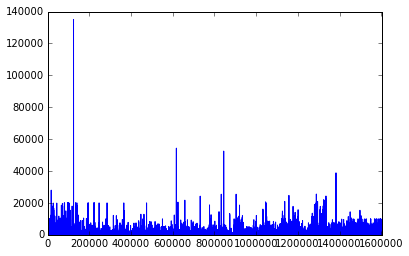

In [71]:
energ_geo['rated_power'].plot()

## Take a look into the statistics of BMWi and BNetzA

In [72]:
# BNetzA
url_eeg2013 ='http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/'\
             'Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/' \
              'ZahlenDatenInformationen/EEGinZahlen_2013.xls;?__blob=publicationFile&v=3'
eeg2013 = pd.ExcelFile(url_eeg2013)
eeg2013.sheet_names

['Inhaltsverzeichnis',
 '1. Allgemeine Erläuterungen',
 '2.1 Überblick Deutschland',
 '2.2 Überblick Bundesländer',
 '2.3 Letzverbraucherabsatz',
 '2.4 Historische Entwicklung',
 '3.1 Wind onshore',
 '3.2 Wind offshore',
 '3.3 PV insgesamt',
 '3.4 PV Kategorien',
 '3.5 Biomasse',
 '3.6 Wasser',
 '3.7 Sonstige Energieträger',
 '4.1 Regelzonen',
 '4.2 Anschlussebenen',
 '4.3 Größenklassen',
 '5. Vermiedene NE']

In [73]:
sta2013 = eeg2013.parse('2.1 Überblick Deutschland', skiprows=4, skip_footer=9)
sta2013

,Unnamed: 0,Wasser,DKG-Gas*,Biomasse,Geothermie,Wind onshore,Wind offshore,Solar,Unnamed: 8
0,Installierte Leistung ingesamt (in MW),1487.23,551.15,6052.43,30.485,33456.7,508.3,36710.1,78796.4
1,Neuinbetriebnahmen (in MW),76.0051,0.658,167.197,11.315,2900.46,240,2643.31,6038.94
2,Installierte Anlagen insgesamt (Anzahl),6972,686,13420,8,22746,113,1429860,1473805
3,Eingespeiste Jahresarbeit (GWh),6265.11,1775.74,36258.4,79.8633,50802.7,904.818,28785.1,124872
4,Vergütungszahlungen (Mio.€),420.232,48.1669,6158.38,18.6547,3523.23,122.603,9346.04,19637.3
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Angaben nach Vergütungsarten 2013,Erneuerbare Energieträger nach dem EEG,NaN,NaN,NaN,NaN,NaN,NaN,Summe
7,NaN,Wasser,DKG-Gas*,Biomasse,Geothermie,Wind onshore,Wind offshore,Solar,NaN
8,Feste Einspeisevergütung nach § 16 EEG 2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
url_reg2014  ='http://www.erneuerbare-energien.de/EE/Redaktion/DE/Downloads/zeitreihen-zur-entwicklung-der' \
             '-erneuerbaren-energien-in-deutschland-1990-2014-excel.xlsx;?__blob=publicationFile&v=5'

reg2014 = pd.ExcelFile(url_reg2014)   
sta2014 = reg2014.parse('4', skiprows=7, skip_footer=7)
    

In [75]:
sta2014.T

,0,1,2,3,4,5,6,7,8,9,10,11
Angaben in [MW],Wasserkraft 1),Windenergie an Land,Windenergie auf See 2),Photovoltaik,biogene Festbrennstoffe,biogene flüssige Brennstoffe,Biogas und Biomethan 3),Klärgas 4),Deponiegas,Geothermie,Gesamt,nachrichtlich: biogener Anteil des Abfalls 5)
1990,3982,55,0,2,64,0,1,5,59,0,4168,550
1991,4033,106,0,2,64,0,2,5,64,0,4276,550
1992,4049,174,0,6,65,0,2,4,68,0,4368,550
1993,4117,326,0,9,72,0,3,4,95,0,4626,564
1994,4211,618,0,12,80,0,4,5,119,0,5049,499
1995,4348,1121,0,18,80,0,9,6,132,0,5714,509
1996,4305,1549,0,28,93,0,15,8,145,0,6143,551
1997,4296,2089,0,42,115,0,19,9,158,0,6728,527
1998,4369,2877,0,54,135,0,43,115,168,0,7761,540


# Create final dataframe

In [76]:
df_columns = ['start_up_date','rated_power','generation_type',
              'subtype','thermal_capacity','city', 'postcode',
              'tso','longitude','latitude','eeg_id',
              'voltage_level','source']

In [77]:
transp_data = ren_geo.loc[:, df_columns]
energymap_data = energ_geo.loc[:, df_columns]

# delete the rest of columns
transp_data.reset_index(drop=True)
energymap_data.reset_index(drop=True)
print('done')

done


In [78]:
transp_data.head()

,start_up_date,rated_power,generation_type,subtype,thermal_capacity,city,postcode,tso,longitude,latitude,eeg_id,voltage_level,source
0,1895-11-16,70.000,hydro,NaN,NaN,NaN,885XX,TransnetBW GmbH,9.443120,48.135032,E16869000000000,NS,TransnetBW
1,1899-11-01,240.000,hydro,NaN,NaN,NaN,424XX,Amprion,7.272179,51.207199,E30000000242363,MS,Amprion
2,1899-12-30,29.375,solar,NaN,NaN,NaN,735XX,TransnetBW GmbH,9.825670,48.819950,E16568363000000,NS,TransnetBW
3,1899-12-31,13.000,hydro,NaN,NaN,NaN,573XX,Amprion,8.281027,51.080677,E30000000060527,NS,Amprion
4,1899-12-31,490.000,hydro,NaN,NaN,NaN,754XX,TransnetBW GmbH,8.845985,48.966367,E17149000000000,MS,TransnetBW


# Geoplot testing

* use energy map to get gps by eeg_id
* transform UTM to GPS by https://pypi.python.org/pypi/utm
* use plz.sql to find the rest


In [79]:
def draw_germany():
    """Returns a basemap centered on Germany"""
    plt.figure(figsize=(14, 10))
    return Basemap(projection='lcc', resolution='l',
                   llcrnrlon= 5.87, urcrnrlon=16.04,
                   llcrnrlat= 47, urcrnrlat= 55.1,
                   lat_1=47.26, lat_2=56, lon_0=6,
                   area_thresh=10000)


/home/leppi/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


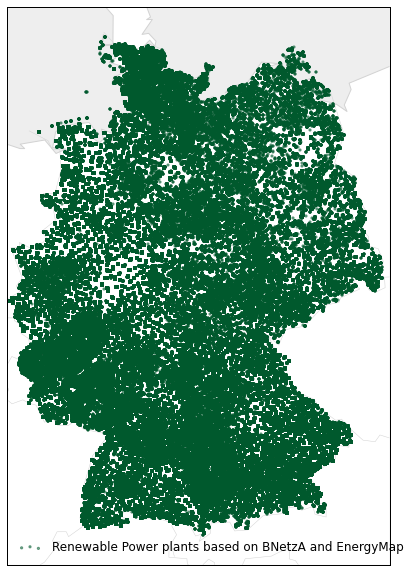

In [80]:
m = draw_germany()
# Draw map background
m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

# get coordinates
lon = np.array(energymap_data.longitude)
lat = np.array(energymap_data.latitude)

# Make plot settings
style = dict(s=5, marker='o', alpha=0.5, zorder=2)
m.scatter(lon,lat, latlon=True,
          label='Renewable Power plants based on BNetzA and EnergyMap',
          color='#00592D', **style)

plt.legend(loc='lower left', frameon=False)

/home/leppi/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


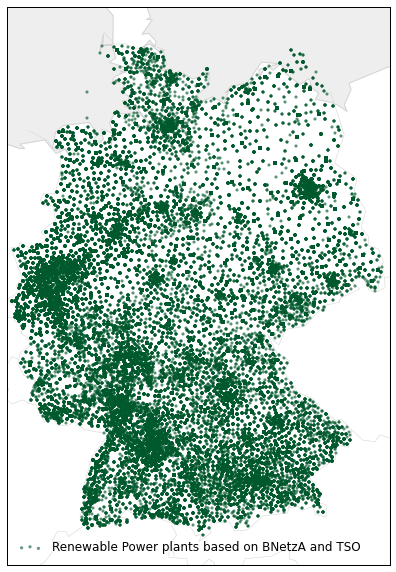

In [81]:
m = draw_germany()
# Draw map background
m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

# get coordinates
lon = np.array(transp_data.longitude)
lat = np.array(transp_data.latitude)

# Make plot settings
style = dict(s=5, marker='o', alpha=0.5, zorder=2)
m.scatter(lon,lat, latlon=True,
          label='Renewable Power plants based on BNetzA and TSO',
          color='#00592D', **style)

plt.legend(loc='lower left', frameon=False)

# Documenting the meta data

The data packages meta data are provided in the specific format JSON, as proposed by the Open Knowledge Foundation. Please see the Frictionless Data project by OKFN (http://data.okfn.org/) and the Data Package specifications (http://dataprotocols.org/data-packages/) for more details.

In order to keep the notebook more readable, we formulate the metadata in the human-readable YAML format using a multi-line string and then parse the string into a Python dictionary and save that as a JSON file.

In [82]:
# Here we define the meta data of the resulting data package.

metadata = """
name: opsd-renewable-master-register-germany
title: Test data for master register of renewable power plants in Germany.
description: This dataset is for OPSD testing purposes and contains the master data of renewable power plants Germany.
version: 0.0.2
keywords: [master data register,power plants,renewables,germany]
resources:
      path: renewable_power_plants_germany.csv
      format: csv
      mediatype: text/csv
      schema:  # Schema according to: http://dataprotocols.org/json-table-schema/        
          fields:
            - name: start_up_date
              description: Date of start up
              type: datetime
              format: YYYY-MM-DDThh:mm:ssZ  # This MUST be in ISO 8601 format of YYYY-MM-DDThh:mm:ssZ in UTC time according to http://dataprotocols.org/json-table-schema/
            - name: rated_power
              description: Rated power in kW
              type: number
              format: float
            - name: generation_type
              description: Type of generation / energy source
              type: number
            - name: subtype,
              description: subtype of generation
              type: text
            - name: thermal_capacity
              description: Installed thermal capacity in kW
              type: number
            - name: city
              description: City name of location
              type: text
            - name: tso
              description: Name of TSO  
              type: text    
            - name: longitude
              description: GPS Longitude coordinates
              type: number             
            - name: latitude
              description: GPS Latitude coordinates 
              type: number
            - name: eeg_id
              description: eeg remuneration number
              type: text
            - name: voltage_level
              description: Volatage level of grid connection
              type: text             
            - name: source
              description: Source name of entry
              type: text
licenses:
    - url: http://example.com/license/url/here
      name: License Name Here
      version: 1.0
      id: license-id-from-open
sources:
    - name: EnergyMap.info,
      web: http://www.energymap.info/download.html
    - name: Bundesnetzagentur - Veröffentlichung von im Anlagenregister registrierten Daten,
      web: http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/Anlagenregister_Veroeffentlichung/Anlagenregister_Veroeffentlichungen_node.html
    - name: Bundesnetzagentur - Datenmeldungen und EEG-Vergütungssätze für Photovoltaikanlagen,
      web: http://www.bundesnetzagentur.de/cln_1431/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/DatenMeldgn_EEG-VergSaetze/DatenMeldgn_EEG-VergSaetze_node.html    
    - name: Netz-transparenz.de Informationsplattform der deutschen Übertragungsnetzbetreiber, 
      web: https://www.netztransparenz.de/de/Anlagenstammdaten.htm
maintainers:
    - name: OPSD Project,
      email: wolf-dieter.bunke@uni-flensburg.de,
      web: http://open-power-system-data.org/
views:
    # You can put hints here which kind of graphs or maps make sense to display your data. 
    # Data Package Viewer at http://data.okfn.org/tools/view automatically display visualazations of your data.
    # See http://data.okfn.org/doc/data-package#views for more details.    
# extend your datapackage.json with attributes that are not
# part of the data package spec
# you can add your own attributes to a datapackage.json, too
openpowersystemdata-enable-listing: True  # This is just an example we don't actually make use of yet.
"""

metadata = yaml.load(metadata)

datapackage_json = json.dumps(metadata, indent=4, separators=(',', ': '))

# Write Data Package to local memory

The Frictionless Data project's suggestions (see http://data.okfn.org/) are followed to write a data package to the local memory.

The data package consists of:
 * **datapackage.json** A file containing the meta data of the data package
 * ***.csv** One or multiple CSV data files
 * **README.md** A readme (which is a copy of this Jupyter Notebook converted to markdown format)

Following this file structure allows a number of tools (http://data.okfn.org/tools) designed specifically for data packages.

In [83]:
path_package = 'output/datapackage_renewables'

os.makedirs(path_package, exist_ok=True)
    
energymap_data.to_csv(os.path.join(path_package,
                            'renewable_power_plants_germany.csv'))

with open(os.path.join(path_package, 'datapackage.json'), 'w') as f:
    f.write(datapackage_json)
    
##
# Make sure the filename matches the filename of the notebook itself
##
nb_filename = 'renewable-energy-power-plants_DE.ipynb'

# Save a copy of the notebook to markdown, to serve as the package README file
subprocess.call(['jupyter', 'nbconvert', '--to', 'markdown', nb_filename])
path_readme = os.path.join(path_package, '/README.md')
try:
    os.remove(path_readme)
except Exception:
    pass
os.rename(nb_filename.replace('.ipynb', '.md'), path_readme)

FileNotFoundError: [Errno 2] No such file or directory: 'renewable-energy-power-plants_DE.md' -> '/README.md'